In [1]:

import matplotlib as mpl
mpl.use('Agg')
import os
import h5py
import json
import re
import sys
import datetime
import optparse
import pprint
import cPickle as pkl
import tifffile as tf
import pylab as pl
import numpy as np
from scipy import ndimage
import cv2
import glob
from scipy.optimize import curve_fit
import seaborn as sns
from pipeline.python.retinotopy import visualize_rois as vis
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy as sp
import pandas as pd

from pipeline.python.utils import natural_keys, label_figure, replace_root
from pipeline.python.retinotopy import visualize_rois as visroi
from pipeline.python.retinotopy import do_retinotopy_analysis as ra
from pipeline.python.retinotopy import target_visual_field as targ
from matplotlib.patches import Ellipse


pp = pprint.PrettyPrinter(indent=4)
from scipy.signal import argrelextrema


In [2]:
%matplotlib notebook

In [3]:

def extract_options(options):
    
    parser = optparse.OptionParser()

    parser.add_option('-D', '--root', action='store', dest='rootdir', default='/n/coxfs01/2p-data', help='data root dir (root project dir containing all animalids) [default: /nas/volume1/2photon/data, /n/coxfs01/2pdata if --slurm]')
    parser.add_option('-i', '--animalid', action='store', dest='animalid', default='', help='Animal ID')

    # Set specific session/run for current animal:
    parser.add_option('-S', '--session', action='store', dest='session', default='', \
                      help='session dir (format: YYYMMDD_ANIMALID')
    parser.add_option('-A', '--acq', action='store', dest='acquisition', default='FOV1', \
                      help="acquisition folder (ex: 'FOV1_zoom3x') [default: FOV1]")
    parser.add_option('-R', '--run', action='store', dest='run', default='retino_run1', \
                      help="name of run dir containing tiffs to be processed (ex: gratings_phasemod_run1)")
    parser.add_option('-t', '--retinoid', action='store', dest='retinoid', default='analysis001', \
                      help="name of retino ID (roi analysis) [default: analysis001]")
    
    parser.add_option('--angular', action='store_false', dest='use_linear', default=True, \
                      help="Plot az/el coordinates in angular spce [default: plots linear coords]")
#     parser.add_option('-e', '--thr-el', action='store', dest='fit_thresh_el', default=0.2, \
#                       help="fit threshold for elevation [default: 0.2]")
#     parser.add_option('-a', '--thr-az', action='store', dest='fit_thresh_az', default=0.2, \
#                       help="fit threshold for azimuth [default: 0.2]")
    
    (options, args) = parser.parse_args(options)

    return options

In [4]:
def load_retino_analysis_info(animalid, session, fov, run, retinoid, use_pixels=False, rootdir='/n/coxfs01/2p-data'):
    
    run_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, run))[0]
    fov = os.path.split(os.path.split(run_dir)[0])[-1]
    print("FOV: %s, run: %s" % (fov, run))
    retinoids_fpath = glob.glob(os.path.join(run_dir, 'retino_analysis', 'analysisids_*.json'))[0]
    with open(retinoids_fpath, 'r') as f:
        rids = json.load(f)
    if use_pixels:
        roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] == 'pixels']
    else:
        roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] != 'pixels']
    if retinoid not in roi_analyses:
        retinoid = sorted(roi_analyses, key=natural_keys)[-1] # use most recent roi analysis
        print("Fixed retino id to most recent: %s" % retinoid)
        
    return retinoid, rids[retinoid]


In [5]:
def get_retino_stimulus_info(mwinfo, runinfo):
    
    stiminfo = dict((cond, dict()) for cond in conditions)
    for curr_cond in conditions:
        # get some info from paradigm and run file
        stimfreq = np.unique([v['stimuli']['scale'] for k,v in mwinfo.items() if v['stimuli']['stimulus']==curr_cond])[0]
        stimperiod = 1./stimfreq # sec per cycle
        
        n_frames = runinfo['nvolumes']
        fr = runinfo['frame_rate']
        
        n_cycles = int(round((n_frames/fr) / stimperiod))
        #print n_cycles

        n_frames_per_cycle = int(np.floor(stimperiod * fr))
        cycle_starts = np.round(np.arange(0, n_frames_per_cycle * n_cycles, n_frames_per_cycle)).astype('int')

        stiminfo[curr_cond] = {'stimfreq': stimfreq,
                               'frame_rate': fr,
                               'n_reps': len(trials_by_cond[curr_cond]),
                               'nframes': n_frames,
                               'n_cycles': n_cycles,
                               'n_frames_per_cycle': n_frames_per_cycle,
                               'cycle_start_ixs': cycle_starts
                              }

    return stiminfo

In [6]:
def get_parsed_cycles(rid, roi_traces, stiminfo, chunksize=1):

    
    parsed_traces = dict()
    parsed_cycle_ixs = dict()
    for curr_cond, trial_nums in stiminfo['trials_by_cond'].items():
        ncycles = stiminfo[curr_cond]['n_cycles']
        resampled = ncycles/chunksize
        
        fr_per_cycle = stiminfo[curr_cond]['n_frames_per_cycle'] * chunksize
        cycle_starts = stiminfo[curr_cond]['cycle_start_ixs'][0::chunksize]
        #print len(cycle_starts)
        ntrials = len(trials_by_cond[curr_cond])

        roi_cycles = []; cycle_indices = [];
        curr_roi_tracearray = roi_traces[curr_cond]
        for tix in np.arange(0, curr_roi_tracearray.shape[0]):

            roi_trace = curr_roi_tracearray[tix, :] #extr_traces['File%03d' % trial]['processed'][rid, :]

            nparsed_cycles = len(cycle_starts) # ncycles/resampled #chunksize
            ptraces_currtrial = np.zeros((nparsed_cycles, fr_per_cycle))
            cindices_currtrial = np.zeros((nparsed_cycles, chunksize))
            cyc_counter = 0
            for cycle in np.arange(0, nparsed_cycles):
                ixs_to_fill = cycle_starts[cycle] + fr_per_cycle
                if ixs_to_fill > len(roi_trace):
                    roi_trace = np.pad(roi_trace, ((0, ixs_to_fill - len(roi_trace))),\
                                       mode='constant', constant_values=0)
                ptraces_currtrial[cycle, :] = roi_trace[cycle_starts[cycle]:(cycle_starts[cycle]+fr_per_cycle)]
                cindices_currtrial[cycle, :] = stiminfo[curr_cond]['cycle_start_ixs'][cyc_counter:cyc_counter+chunksize]
                cyc_counter += chunksize
                
            roi_cycles.append(ptraces_currtrial)
            cycle_indices.append(cindices_currtrial)
        
        parsed_traces[curr_cond] = np.array(roi_cycles)
        parsed_cycle_ixs[curr_cond] = np.array(cycle_indices) #[s for s in cycle_starts] #[s/chunksize for s in cycle_starts]
        
    return parsed_traces, parsed_cycle_ixs

In [7]:
# Interpolate bar position for found SI frame using upsampled MW tstamps and positions:


def get_interp_positions(condname, mwinfo, stiminfo, trials_by_cond):
    mw_fps = 1./np.diff(np.array(mwinfo[str(trials_by_cond[condname][0])]['stiminfo']['tstamps'])/1E6).mean()
    si_fps = stiminfo[condname]['frame_rate']
    print "[%s]: Downsampling MW positions (sampled at %.2fHz) to SI frame rate (%.2fHz)" % (condname, mw_fps, si_fps)

    si_cyc_ixs = stiminfo[condname]['cycle_start_ixs']
    si_tstamps = runinfo['frame_tstamps_sec']


    #fig, axes = pl.subplots(1, len(trials_by_cond[condname]))

    stim_pos_list = []
    stim_tstamp_list = []

    for ti, trial in enumerate(trials_by_cond[condname]):
        #ax = axes[ti]

        pos_list = []
        tstamp_list = []
        mw_cyc_ixs = mwinfo[str(trial)]['stiminfo']['start_indices']
        for cix in np.arange(0, len(mw_cyc_ixs)):
            if cix==len(mw_cyc_ixs)-1:
                mw_ts = [t/1E6 for t in mwinfo[str(trial)]['stiminfo']['tstamps'][mw_cyc_ixs[cix]:]]
                xs = mwinfo[str(trial)]['stiminfo']['values'][mw_cyc_ixs[cix]:]
                si_ts = si_tstamps[si_cyc_ixs[cix]:]
            else:
                mw_ts = np.array([t/1E6 for t in mwinfo[str(trial)]['stiminfo']['tstamps'][mw_cyc_ixs[cix]:mw_cyc_ixs[cix+1]]])
                xs = np.array(mwinfo[str(trial)]['stiminfo']['values'][mw_cyc_ixs[cix]:mw_cyc_ixs[cix+1]])
                si_ts = si_tstamps[si_cyc_ixs[cix]:si_cyc_ixs[cix+1]]

            recentered_mw_ts = [t-mw_ts[0] for t in mw_ts]
            recentered_si_ts = [t-si_ts[0] for t in si_ts]

            # Since MW tstamps are linear, SI tstamps linear, interpolate position values down to SI's lower framerate:
            interpos = sp.interpolate.interp1d(recentered_mw_ts, xs, fill_value='extrapolate')
            resampled_xs = interpos(recentered_si_ts)

            pos_list.append(pd.Series(resampled_xs, name=trial))
            tstamp_list.append(pd.Series(recentered_si_ts, name=trial))

            #ax.plot(recentered_mw_ts, xs, 'ro', alpha=0.5, markersize=2)
            #ax.plot(recentered_si_ts, resampled_xs, 'bx', alpha=0.5, markersize=2)

        pos_vals = pd.concat(pos_list, axis=0).reset_index(drop=True) 
        tstamp_vals = pd.concat(tstamp_list, axis=0).reset_index(drop=True)

        stim_pos_list.append(pos_vals)
        stim_tstamp_list.append(tstamp_vals)

    stim_positions = pd.concat(stim_pos_list, axis=1)
    stim_tstamps = pd.concat(stim_tstamp_list, axis=1)


    return stim_positions, stim_tstamps


In [8]:
def plot_parsed_cycles_by_roi(parsed_traces, parsed_cycle_ixs):

    fig, axes = pl.subplots(2,1)

    for axi, (c1, c2) in enumerate([('left', 'right'), ('bottom', 'top')]):
        ax = axes[axi]

        # Plot FW direction of azimuth/elev
        nreps, ncycles_orig, nframes_orig = parsed_traces[c1].shape
        for rep in np.arange(0, nreps):
            ax.plot(parsed_traces[c1][rep,:,:].mean(axis=0), c1_color, lw=0.5)   # Plot each "rep" of chunked cycle
        ax.plot(parsed_traces[c1].mean(axis=1).mean(axis=0), c1_color, label=c1) # Plot average chunked cycle
        ax.legend()
        subcycle_ixs = parsed_cycle_ixs[c1].mean(axis=0)[0,: ]
        for cyc in subcycle_ixs:
            ax.axvline(x=cyc, color='k', lw=0.5)       # Plot cycle start lines

        # Plot BW direction of azimuth/elev
        nreps, ncycles_orig, nframes_orig = parsed_traces[c2].shape
        for rep in np.arange(0, nreps):
            ax.plot(parsed_traces[c2][rep,:,:].mean(axis=0), c2_color, lw=0.5)
        ax.plot(parsed_traces[c2].mean(axis=1).mean(axis=0), c2_color, label=c2)
        ax.legend()
        subcycle_ixs = parsed_cycle_ixs[c2].mean(axis=0)[0,: ]
        for cyc in subcycle_ixs: #parsed_cycle_ixs[c2][0:chunksize]:
            ax.axvline(x=cyc, color='k', lw=0.5)
            
    return fig


In [756]:
# def get_cycle_onsets(avg_cycle_c1, cycle_starts, fr_per_cyc, baseline_window_size=10., nstds_above_baseline=1.5):

#     # Find peaks for each cycle:
#     cmaxima = []
#     cminima = []
#     onsets = []
#     baseline_values= []
#     baseline_indices = []
    
#     # Get max, min, and "onset" for each cycle in "mini" roi-trace:
#     try:
#         for cyc_ix, cyc_start in enumerate(cycle_starts):

#             curr_frames = np.arange(cyc_start, cyc_start+fr_per_cyc)
#             curr_values = avg_cycle_c1[curr_frames]
#             cmax = int(np.where(curr_values==curr_values.max())[0][0])
#             startix = 0
#             if cyc_ix == 0 and cmax == 0:
#                 while cmax < (fr_per_cyc / len(cycle_starts)): #4:
#                     print "Getting new cmax..."
#                     cmax = int(np.where(curr_values[startix:]==curr_values[startix:].max())[0][0])
#                     startix += 1
#                 cmax = cmax + startix
#             cmaxima.append((curr_frames[cmax], curr_values.max()))

#             minval = curr_values[startix:cmax].min()
#             cmin = int(np.where(curr_values[startix:cmax]==minval)[0][0]) + startix
#             cminima.append((curr_frames[cmin], minval))

#             baseline = curr_values[cmin-baseline_window_size:cmin] #+baseline_window_size]
#             bindices = curr_frames[cmin-baseline_window_size:cmin] #+baseline_window_size]
#             if cmin-baseline_window_size < 0: # include frames from previous "cycle" since likely at very edge
#                 if cyc_ix == 0:
#                     # No previous cycle to borrow frames from
#                     bindices = curr_frames[0:cmin+baseline_window_size]
#                     baseline = curr_values[0:cmin+baseline_window_size]
#                 else:
#                     prev_frames = np.arange(cycle_starts[cyc_ix-1], cycle_starts[cyc_ix-1]+fr_per_cyc)
#                     prev_values = avg_cycle_c1[prev_frames]
#                     nprev = baseline_window_size-cmin
#                     bindices = curr_frames[0:cmin] #+baseline_window_size]
#                     bindices = sorted(np.append(bindices, prev_frames[-nprev:]))

#                     baseline = prev_values[-nprev:]
#                     baseline = np.append(baseline, curr_values[0:cmin]) #+baseline_window_size])

#             thr_value = baseline.mean() + (baseline.std() * nstds_above_baseline) #curr_values.max()*0.1
#             onset = np.where(np.abs(curr_values[cmin:cmax]-thr_value)\
#                              ==np.min(np.abs(curr_values[cmin:cmax]-thr_value)))[0] + cmin # Only look b/w max/min 

#             onsets.append((curr_frames[onset], curr_values[onset]))
#             baseline_values.append(baseline)
#             baseline_indices.append(bindices)
#     except Exception as e:
#         return None
        
#     loci = {'maxima': cmaxima,
#            'minima': cminima,
#            'onsets': onsets,
#            'baseline_indices': baseline_indices,
#            'baseline_values': baseline_values,
#            'nstds_above_baseline': nstds_above_baseline}
        
#     return loci #cmaxima, cminima, onsets, (baseline_indices, baseline_values)

        

In [287]:


def plot_cycle_loci(avg_cycle_c1, cycle_starts, loci, avg_pos_c1=None, label='cond', ax=None, color='k'):

    if ax is None:
        fig, ax = pl.subplots(figsize=(6,3))

    # Can either plot by frames, or by corresponding bar position:
    if avg_pos_c1 is None:
        avg_pos_c1 = np.arange(0, len(avg_cycle_c1))
    
    # Plot average "chunked-cycle" and each repetition of the full cycle
    ax.plot(avg_pos_c1, avg_cycle_c1, color=color, lw=0.5, label=label)
    for cyc in cycle_starts:
        cycle_ix = avg_pos_c1[cyc]
        ax.axvline(x=cycle_ix, color=color, linestyle='--', lw=0.5)

    # Plot maxima:
    for c in loci['maxima']:
        c_ix = avg_pos_c1[c[0]] 
        c_val = c[1]
        ax.plot(c_ix, c_val, 'k+', markersize=10)

    # Plot minima:
    for c in loci['minima']: #cmin:
        c_ix = avg_pos_c1[c[0]]
        c_val = c[1]
        if color != 'k':
            ax.plot(c_ix, c_val, 'k.', markersize=10)
        else:
            ax.plot(c_ix, c_val, 'y.', markersize=10)

    # Plot "onset" defined by threshold:
    for ons in loci['onsets']:
        if not ons[0].size:
            continue
        on_ix = avg_pos_c1[ons[0]]
        on_val = ons[1]
        
        if color != 'k':
            ax.plot(on_ix, on_val, 'k*', markersize=10)
        else:
            ax.plot(on_ix, on_val, 'g*',  markersize=10)

    # Plot baseline values used to calculate onset reference:
    for bi, bv in zip(loci['baseline_indices'], loci['baseline_values']): #bas_ixs, bas_vals):
        bi_ixs = [avg_pos_c1[b] for b in bi]
        ax.plot(bi_ixs, bv, 'gray')
        
    return ax

In [288]:

def plot_cycle_onsets(avg_cycle_c1, cycle_starts, loci, avg_pos_c1=None, label='cond', ax=None, color='k'): 

    if ax is None:
        fig, ax = pl.subplots(figsize=(6,3))

    # Can either plot by frames, or by corresponding bar position:
    if avg_pos_c1 is None:
        avg_pos_c1 = np.arange(0, len(avg_cycle_c1))
    
    # Plot average "chunked-cycle" and each repetition of the full cycle
    #ax.plot(avg_pos_c1, avg_cycle_c1, color='k', lw=0.5)
    for cix, cyc in enumerate(cycle_starts):
        if cix == len(cycle_starts)-1:
            ax.plot(avg_pos_c1[cyc:], avg_cycle_c1[cyc:], color='k', lw=0.5)
        else:
            ax.plot(avg_pos_c1[cyc:cycle_starts[cix+1]], avg_cycle_c1[cyc:cycle_starts[cix+1]], color='k', lw=0.5)
        
        
        cycle_ix = avg_pos_c1[cyc]
        ax.axvline(x=cycle_ix, color='k', linestyle='--', lw=0.2)

    # Plot "onset" defined by threshold:
    for ix, (mxs, ons) in enumerate(zip(loci['maxima'], loci['onsets'])):
        if not ons[0].size:
            continue
        if ix == 0: #len(loci['maxima'])-1:
            label = label
        else:
            label = None
        ax.plot(avg_pos_c1[int(ons[0]):int(mxs[0])], avg_cycle_c1[int(ons[0]):int(mxs[0])], \
                color=color, label=label, alpha=0.7, lw=1.0)
    return ax                

In [289]:
def get_loci_from_averaged_cycle(parsed_traces, parsed_cycle_ixs, stiminfo, \
                                 nstds_above_baseline=2., window_nsecs=1.):

    loci = dict()
    for aix, (c1, c2) in enumerate([('left', 'right'), ('bottom', 'top')]):

        # Plot direction 1
        avg_cycle_c1 = parsed_traces[c1].mean(axis=1).mean(axis=0)
        cycle_starts = [int(c) for c in parsed_cycle_ixs[c1].mean(axis=0)[0,:]] # only need first chunk
        fr_per_cyc = stiminfo[c1]['n_frames_per_cycle'] 
        baseline_window_size = int(round(stiminfo[c1]['frame_rate']*window_nsecs))
        loci[c1] = get_cycle_onsets(avg_cycle_c1, cycle_starts, fr_per_cyc,
                                                                     baseline_window_size=baseline_window_size, 
                                                                     nstds_above_baseline=nstds_above_baseline)

        # Plot direction 2
        avg_cycle_c2 = parsed_traces[c2].mean(axis=1).mean(axis=0)
        cycle_starts = [int(c) for c in parsed_cycle_ixs[c2].mean(axis=0)[0,:]] # only need first chunk
        fr_per_cyc = stiminfo[c2]['n_frames_per_cycle'] 
        baseline_window_size = int(round(stiminfo[c2]['frame_rate']*window_nsecs))
        loci[c2] = get_cycle_onsets(avg_cycle_c2, cycle_starts, fr_per_cyc,
                                                                     baseline_window_size=baseline_window_size, 
                                                                     nstds_above_baseline=nstds_above_baseline)

    return loci 

In [290]:
def plot_loci_from_averaged_cycle(parsed_traces, parsed_cycle_ixs, loci, average_positions={}):
    fig, axes = pl.subplots(1, 2, figsize=(12,4))

    for aix, (c1, c2) in enumerate([('left', 'right'), ('bottom', 'top')]):
        ax = axes[aix]
        

        # Plot forward direction
        avg_pos_c1 = average_positions[c1] if c1 in average_positions.keys() else None
        avg_cycle_c1 = parsed_traces[c1].mean(axis=1).mean(axis=0)
        cycle_starts = [int(c) for c in parsed_cycle_ixs[c1].mean(axis=0)[0,:]] # only need first chunk
        ax = plot_cycle_onsets(avg_cycle_c1, cycle_starts, loci[c1], ax=ax, avg_pos_c1=avg_pos_c1,
                               label=c1, color=c1_color)
        
        # Plot reverse direction
        avg_pos_c2 = average_positions[c2] if c2 in average_positions.keys() else None
        avg_cycle_c2 = parsed_traces[c2].mean(axis=1).mean(axis=0)
        cycle_starts = [int(c) for c in parsed_cycle_ixs[c2].mean(axis=0)[0,:]] # only need first chunk
        ax = plot_cycle_onsets(avg_cycle_c2, cycle_starts, loci[c2], ax=ax, avg_pos_c1=avg_pos_c2,
                               label=c2, color=c2_color)
        
        ax.set_xlabel('time (frames)')
        ax.legend(loc='upper right')

        ax.set_title('%s, %s' % (c1, c2)) #cond)
        sns.despine(trim=True, offset=4, ax=ax)
        
    return fig

In [291]:
def get_positions_per_cycle(stim_positions, parsed_cycle_ixs):
    positions_by_cycle = {}
    
    for c1 in stim_positions.keys():
        
        # Use indices of parsed "cycle chunk" (should be nchunks=ncycles/chunksize 'traces' to match position to)
        # ----------------------------------------------------------------------------
        # C1: Average position values to match chunked traces:
        mean_pos_vals1 = stim_positions[c1].mean(axis=1)
        avg_pos_list1 = []
        cycle_starts = [int(c) for c in parsed_cycle_ixs[c1].mean(axis=0)[:, 0]] #[0:chunksize]
        for cix, cyc in enumerate(cycle_starts):
            #print cix, cyc
            if cix == len(cycle_starts)-1:
                avg_pos_list1.append(mean_pos_vals1[cyc:])
            else:
                avg_pos_list1.append(mean_pos_vals1[cyc:cycle_starts[cix+1]])
        for ai, a in enumerate(avg_pos_list1):
            avg_pos_list1[ai] = a[0:stiminfo[c1]['n_frames_per_cycle']*chunksize]

        positions_by_cycle[c1] = avg_pos_list1
    
    return positions_by_cycle

        

def loci_to_rf_parameters(loci, positions_by_cycle):
    rf_edges = {}
    for c1 in loci.keys():
        avg_pos_list = positions_by_cycle[c1]

        # For each reptition of the "chunked cycle" find corresponding onset position:
        # ----------------------------------------------------------------------------
        onsets = loci[c1]['onsets']

        onset_positions = []; peak_positions = [];
        nchunks = len(avg_pos_list)
        for peak, onset, cyc, bar_pos in zip(loci[c1]['maxima'], onsets, np.arange(0, nchunks), avg_pos_list):
            onset_positions.append(float(bar_pos.iloc[onset[0]]))
            peak_positions.append(float(bar_pos.iloc[peak[0]]))

        mean_onset_pos = np.mean(onset_positions)
        std_onset_pos = np.std(onset_positions)
        mean_peak_pos = np.mean(peak_positions)
        
        print "[%s] Onset %.2f deg (std %.2f). Peak @ %.2f deg." % (c1, mean_onset_pos, std_onset_pos, mean_peak_pos)

        rf_edges[c1] = {'onset_positions': np.array(onset_positions),
                        'peak_positions': np.array(peak_positions),
                        'loci': loci[c1],
                        'nchunks': nchunks,
                        'bar_positions': avg_pos_list}
    
    
    return rf_edges

def get_rf_estimate_params(rid, absolute_coords, rf_edges, verbose=False):
    rfparams = {}
    
    xpos_phase = absolute_coords['linX'][rid]
    ypos_phase = absolute_coords['linY'][rid]

    right_edge = rf_edges['right']['onset_positions'].mean()
    left_edge = rf_edges['left']['onset_positions'].mean()
    top_edge = rf_edges['top']['onset_positions'].mean()
    bottom_edge = rf_edges['bottom']['onset_positions'].mean()

    if verbose:
        print "ROI %i - summary - " % int(rid+1)
        print "Phase coords (x, y): (%.2f, %.2f)" % (xpos_phase, ypos_phase)
        print "Left/Right edges: [%.2f, %.2f]" % (left_edge, right_edge)
        print "--> left onsets:", rf_edges['left']['onset_positions']
        print "--> right onsets:", rf_edges['right']['onset_positions']

        print "Bottom/Top edges: [%.2f, %.2f]" % (bottom_edge, top_edge)
        print "--> top onsets:", rf_edges['top']['onset_positions']
        print "--> bottom onsets:", rf_edges['bottom']['onset_positions']

    rfparams = {'phase_coords': (xpos_phase, ypos_phase),
                'azimuth_bounds': (left_edge, right_edge),
                'elevation_bounds': (bottom_edge, top_edge)}

    return rfparams



def plot_roi_RF(rfparams, screen_info):
    
# ells = [Ellipse(xy=[linX[ri], linY[ri]], width=az_rfs[ri], height=el_rfs[ri]) for ri in range(nrois)
#                 if az_rfs[ri] > 0 and el_rfs[ri] > 0]

    left, right = rfparams['azimuth_bounds']
    top, bottom = rfparams['elevation_bounds']

    xpos_phase, ypos_phase = rfparams['phase_coords'
                                     ]
    x_center = left + (right - left)/2 #absolute_coords['linX'][rid]
    y_center = bottom + (top - bottom)/2
    ells = [Ellipse(xy=[x_center, y_center], \
                    width=right-left,\
                    height=top-bottom)]

    screen_aspect = screen_info['azimuth']/screen_info['elevation']
    fig, ax = pl.subplots(1, figsize=(screen_aspect*4, 4))
    ax.clear()
    ax.plot(xpos_phase, ypos_phase, 'r*', label='phase')
    ax.plot(x_center, y_center, 'b*', label='midpoint')
    ax.set_xlim([-screen_info['azimuth']/2, screen_info['azimuth']/2])
    ax.set_ylim([-screen_info['elevation']/2, screen_info['elevation']/2])


    for ei,e in enumerate(ells): #[0:20]):
        ax.add_artist(e)
        e.set_alpha(1)
        e.set_facecolor('none')
        e.set_linestyle('-')
        e.set_edgecolor('k')
    ax.legend()

    return fig


# Select data set

In [269]:
#options = ['-i', 'JC047', '-S', '20190215', '-A', 'FOV1']
#options = ['-i', 'JC073', '-S', '20190322', '-R', 'retino_run1', '-A', 'FOV1']
options = ['-i', 'JC073', '-S', '20190327', '-R', 'retino_run2', '-A', 'FOV1']

In [270]:
opts = extract_options(options)

rootdir = opts.rootdir
animalid = opts.animalid
session = opts.session
fov = opts.acquisition
run = opts.run
retinoid = opts.retinoid
use_linear = opts.use_linear
#fit_thresh_az = float(opts.fit_thresh_az)
#fit_thresh_el = float(opts.fit_thresh_el) #0.2


# Load data

In [271]:
# Select which retino analysis to use:
use_pixels = False
retinoid, rinfo = load_retino_analysis_info(animalid, session, fov, run, retinoid, 
                                            use_pixels=use_pixels, rootdir=rootdir)

# Create data identifier for figures:
data_identifier = '|'.join([animalid, session, fov, run, retinoid])
print("*** Dataset: %s ***" % data_identifier)

# Get processed retino data:
run_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, run))[0]
processed_dir = glob.glob(os.path.join(run_dir, 'retino_analysis', '%s*' % retinoid))[0]
processed_fpaths = glob.glob(os.path.join(processed_dir, 'files', '*.h5'))
print("Found %i processed retino runs." % len(processed_fpaths))

# Get condition info for trials:
conditions_fpath = glob.glob(os.path.join(run_dir, 'paradigm', 'files', '*.json'))[0]
with open(conditions_fpath, 'r') as f:
    mwinfo = json.load(f)
conditions = list(set([cdict['stimuli']['stimulus'] for trial_num, cdict in mwinfo.items()]))
trials_by_cond = dict((cond, [int(k) for k, v in mwinfo.items() if v['stimuli']['stimulus']==cond]) \
                      for cond in conditions)

# Get run info:
runinfo_fpath = glob.glob(os.path.join(run_dir, '*.json'))[0]
with open(runinfo_fpath, 'r') as f:
    runinfo = json.load(f)
print "---------------------------------"
print "Trials by condN:", trials_by_cond

# Get stimulus info:
stiminfo = get_retino_stimulus_info(mwinfo, runinfo)
stiminfo['trials_by_cond'] = trials_by_cond

# Load raw traces -- Use 'processed' (np-corrected + preprocessing)
extracted_traces_fpath = glob.glob(os.path.join(processed_dir, 'traces', '*.h5'))[0]
extr_traces = h5py.File(extracted_traces_fpath)
print 'Extracted retino traces contains:' 
print '---', extr_traces.keys()
print 'Each parsed file contains:'
print "--- ---", extr_traces[extr_traces.keys()[0]].keys()

print "---------------------------------"
print "Current retino run: %s" % run
print "---------------------------------"
for param in stiminfo['right'].keys():
    if param == 'cycle_start_ixs': continue
    print param, ':', stiminfo['right'][param]

FOV: FOV1_zoom2p0x, run: retino_run2
Fixed retino id to most recent: analysis002
*** Dataset: JC073|20190327|FOV1|retino_run2|analysis002 ***
Found 12 processed retino runs.
---------------------------------
Trials by condN: {u'top': [1, 5, 4], u'right': [3, 6, 9], u'left': [11, 10, 12], u'bottom': [2, 7, 8]}
Extracted retino traces contains:
--- [u'File001', u'File002', u'File003', u'File004', u'File005', u'File006', u'File007', u'File008', u'File009', u'File010', u'File011', u'File012']
Each parsed file contains:
--- --- [u'corrected', u'masks', u'neuropil', u'np_masks', u'processed', u'raw']
---------------------------------
Current retino run: retino_run2
---------------------------------
nframes : 4119
n_cycles : 12
stimfreq : 0.13
frame_rate : 44.6329
n_reps : 3
n_frames_per_cycle : 343


# Get bar positions (MW) and corresponding phase data (SI):

In [272]:
print "-----------------------------------"
print "Getting MW info (stimulus positions)"
stim_positions = dict()
stim_tstamps = dict()
for cond in trials_by_cond.keys():
    stim_positions[cond], stim_tstamps[cond] = get_interp_positions(cond, mwinfo, stiminfo, trials_by_cond)

print "Stimulus conditions (bar start/end):"
for cond in stim_positions.keys():
    print '--- %s: [%.2f, %.2f]' %(cond, stim_positions[cond].iloc[0,:].mean(), stim_positions[cond].iloc[-1,:].mean())



# Get FFT results and format
print "-----------------------------------"
print "Getting formatted FFT analysis"
fit, magratio, phase, trials_by_cond = targ.trials_to_dataframes(processed_fpaths, conditions_fpath)

print "-----------------------------------"
print "Getting screen info"
screen_info = visroi.get_screen_info(animalid, session, fov=fov.split('_')[0], interactive=True, rootdir=rootdir)


-----------------------------------
Getting MW info (stimulus positions)
[top]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
[right]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
[left]: Downsampling MW positions (sampled at 59.81Hz) to SI frame rate (44.63Hz)
[bottom]: Downsampling MW positions (sampled at 59.80Hz) to SI frame rate (44.63Hz)
Stimulus conditions (bar start/end):
--- top: [62.28, -62.86]
--- right: [62.28, -62.81]
--- bottom: [-62.28, 62.93]
--- left: [-62.28, 62.96]
-----------------------------------
Getting formatted FFT analysis
TRIALS BY COND:
{u'top': [1, 5, 4], u'right': [3, 6, 9], u'left': [11, 10, 12], u'bottom': [2, 7, 8]}
Trials: [11, 10, 12, 1, 3, 2, 5, 4, 7, 6, 9, 8]
1: retino_data_FOV1_retino_Slice01_Channel01_File001.h5
2: retino_data_FOV1_retino_Slice01_Channel01_File002.h5
3: retino_data_FOV1_retino_Slice01_Channel01_File003.h5
4: retino_data_FOV1_retino_Slice01_Channel01_File004.h5
5: retino_dat

# Convert phase info to absolute coords

In [691]:

mag_thr = magratio.max(axis=1).max() * 0.3 #0.02
delay_thr = np.pi #/ 2.

absolute_coords = targ.get_absolute_centers(phase, magratio, trials_by_cond, stim_positions, \
                                            equal_travel_lengths=True, absolute=True,
                                            mag_thr=mag_thr, delay_thr=delay_thr)
print 'LinX min/max found:', absolute_coords['linX'].min(), absolute_coords['linX'].max()
print 'LinY min/max found:', absolute_coords['linY'].min(), absolute_coords['linY'].max()

[bottom_pos, left_pos, top_pos, right_pos] = absolute_coords['screen_bb']
print "-----------------------------------"
print "Strongest cells (mag-ratio: %.2f):\n" % mag_thr, absolute_coords['strong_cells']
print "-----------------------------------"


('ROIs with best mag-ratio (n=3, thr=0.01):', [6, 7, 99])
[AZ] Average delay (std): 0.05 (1.79)
[EL] Average delay (std): 0.76 (1.52)
LinX min/max found: -54.656216438 58.090370785
LinY min/max found: -58.2183346418 54.8831559403
-----------------------------------
Strongest cells (mag-ratio: 0.01):
[6, 7, 99]
-----------------------------------


# Set output dir

In [692]:
output_dir = os.path.join(processed_dir, 'visualization', 'rf_estimates')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print "Saving figures to:\n", output_dir

Saving figures to:
/n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_ea177a/visualization/rf_estimates


# Visualize traces for single ROI

6
top: (3, 4119)
right: (3, 4119)
left: (3, 4119)
bottom: (3, 4119)


<IPython.core.display.Javascript object>


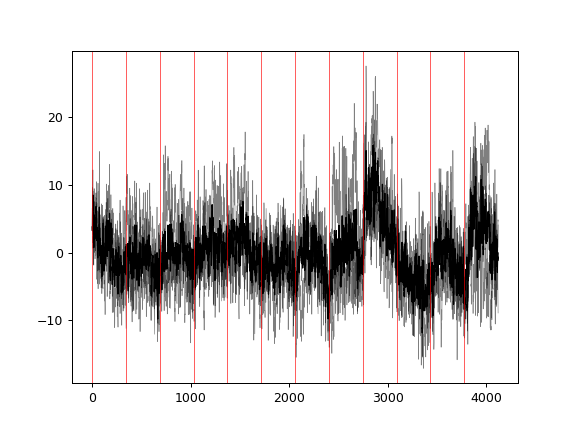

In [695]:
rid = 6
plot_each_condition=True
print rid
c1 = 'left'
tmp_traces= dict()
for condition in trials_by_cond.keys():
    tmp_traces[condition] = np.array([extr_traces['File%03d' % f]['processed'][rid, :] for f in trials_by_cond[condition]])
    print"%s:" % condition, tmp_traces[condition].shape

if plot_each_condition:
    pl.figure()
    for tr in np.arange(0, tmp_traces[c1].shape[0]):
        pl.plot(tmp_traces[c1][tr,:], 'k', lw=0.5, alpha=0.5)
    pl.plot(tmp_traces[c1].mean(axis=0), 'k', lw=1, alpha=1)
    for cyc in stiminfo[c1]['cycle_start_ixs']:
        pl.axvline(x=cyc, color='r', lw=0.5)

#### Filter data

In [696]:

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    #print nyq, normal_cutoff
    b, a = sp.signal.butter(order, normal_cutoff, btype='lowpass', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    #y = sp.signal.lfilter(b, a, data)
    y = sp.signal.filtfilt(b, a, data)
    return y



#### Test different filter params

In [697]:
# Make output dir for processing tests:
curr_figdir = os.path.join(output_dir, 'processing_filters')
if not os.path.exists(curr_figdir):
    os.makedirs(curr_figdir)
print "Saving processing test figs to:\n%s" % curr_figdir

Saving processing test figs to:
/n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_ea177a/visualization/rf_estimates/processing_filters


##### Save filter frequency response for a range of orders

<IPython.core.display.Javascript object>


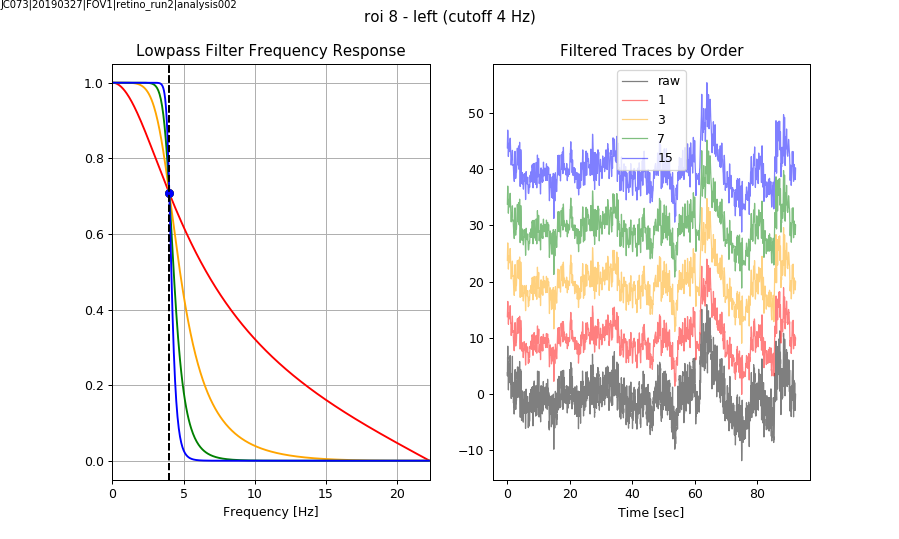

LP_freq_results_by_order_roi00008_cutoff4Hz.png
Saved to: /n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_ea177a/visualization/rf_estimates/parsed_cycles_by_roi


In [731]:
fig, axes = pl.subplots(1,2, figsize=(10,6))
plot_offset = 10

cutoff = 4  # desired cutoff frequency of the filter, Hz
fs = stiminfo[c1]['frame_rate'] #30.0       # sample rate, Hz
filts = []
orders_to_test = [1,3,7, 15]
colors = ['r', 'orange', 'green', 'blue', 'purple']
for ai, order in enumerate(orders_to_test):
    
    ax = axes[0]
    # Get the filter coefficients so we can check its frequency response.
    b, a = butter_lowpass(cutoff, fs, order)

    # Plot the frequency response.
    w, h = sp.signal.freqz(b, a) #, worN=8000)
    ax.plot(0.5*fs*w/np.pi, np.abs(h), colors[ai])
    ax.plot(cutoff, 0.5*np.sqrt(2), marker='o', color=colors[ai], label=order)
    ax.axvline(cutoff, color='k', linestyle='--')
    ax.set_xlim([0, 0.5*fs])
    ax.grid('on')
    ax.set_title("Lowpass Filter Frequency Response")
    ax.set_xlabel('Frequency [Hz]')


    ax = axes[1]
    T = (1./stiminfo[c1]['stimfreq']) * stiminfo[c1]['n_cycles'] #* #5.0         # seconds
    n = int(stiminfo[c1]['nframes']) #int(T * fs) # total number of samples
    t = np.linspace(0, T, n, endpoint=False)
    data = tmp_traces[c1].mean(axis=0) 

    # Filter the data, and plot both the original and filtered signals.
    y = butter_lowpass_filter(data, cutoff, fs, order)
    filts.append(y)
    if ai==0:
        ax.plot(t, data, 'k-', linewidth=1, alpha=0.5, label='raw')
    ax.plot(t, y + ((ai+1)*plot_offset), color=colors[ai], linestyle='-', linewidth=1, alpha=0.5, label=order)
    ax.set_xlabel('Time [sec]')
    ax.set_title('Filtered Traces by Order')

pl.legend()
    
fig.suptitle('roi %i - %s (cutoff %i Hz)' % (int(rid+1), c1, cutoff))
label_figure(fig, data_identifier)
figname = 'LP_freq_results_by_order_roi%05d_cutoff%iHz.png' % (int(rid+1), cutoff)

pl.savefig(os.path.join(curr_figdir, '%s.png' % figname))
print figname
print "Saved to:", curr_figdir

<IPython.core.display.Javascript object>


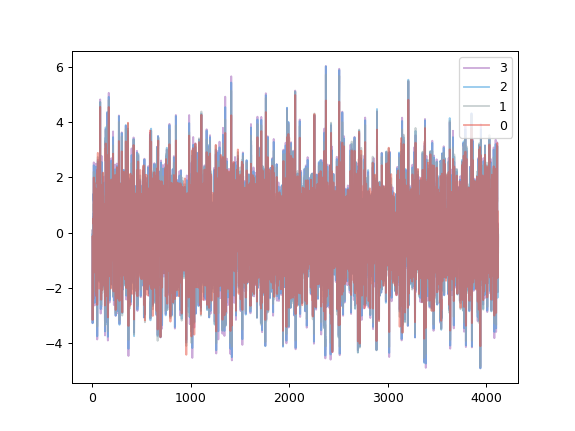

In [626]:
pl.figure()
#pl.plot(data, alpha=1, color='k')
#pl.plot(filts[1], alpha=0.5)
#pl.plot(filts[2], alpha=0.3, color='b')
#pl.plot(filts[-1], alpha=0.5, color='r')
#pl.plot(filts[2], alpha=0.5, color='r')
#pl.plot(filts[-1], alpha=0.5, color='y')
for fi in np.arange(0, len(filts))[::-1]:
    pl.plot(data - filts[fi], label=fi, alpha=0.5)
pl.legend()

##### Plot filter params and example trace

<IPython.core.display.Javascript object>


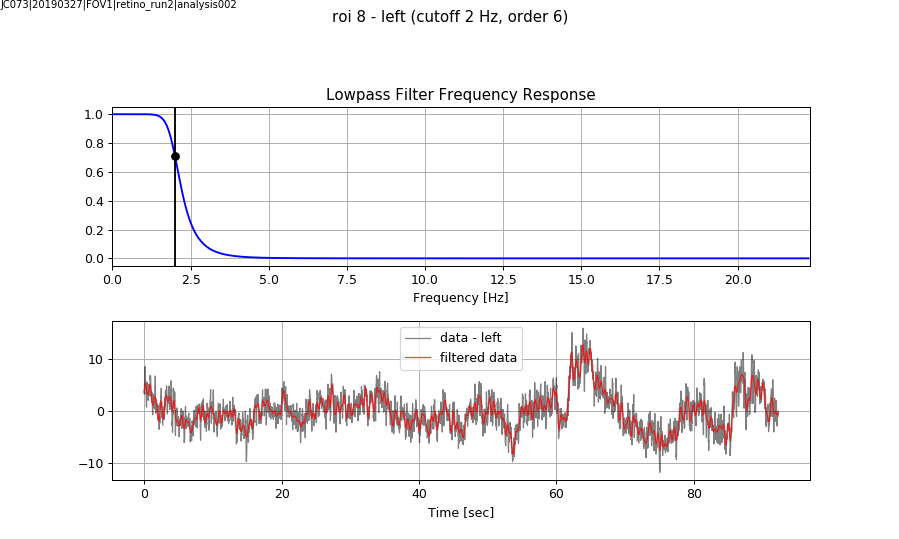

example_filter_results_roi00008_order6_cutoff2Hz
Saved to: /n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_ea177a/visualization/rf_estimates/parsed_cycles_by_roi


In [732]:

# Filter requirements.
order = 6
cutoff = 2  # desired cutoff frequency of the filter, Hz

fs = stiminfo[c1]['frame_rate'] #30.0       # sample rate, Hz


fig = pl.figure(figsize=(10,6))

#for order in [1,3,5,7,9]:
# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = sp.signal.freqz(b, a) #, worN=8000)
pl.subplot(2, 1, 1)
pl.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
pl.plot(cutoff, 0.5*np.sqrt(2), 'ko')
pl.axvline(cutoff, color='k')
pl.xlim(0, 0.5*fs)
pl.title("Lowpass Filter Frequency Response")
pl.xlabel('Frequency [Hz]')
pl.grid()


# Demonstrate the use of the filter.
# First make some data to be filtered.
T = (1./stiminfo[c1]['stimfreq']) * stiminfo[c1]['n_cycles'] #* #5.0         # seconds
n = int(stiminfo[c1]['nframes']) #int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
data = tmp_traces[c1].mean(axis=0) 

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(data, cutoff, fs, order)

pl.subplot(2, 1, 2)
pl.plot(t, data, 'k-', linewidth=1, alpha=0.5, label='data - %s' % c1)
pl.plot(t, y, 'r-', linewidth=1, alpha=0.75, label='filtered data')
pl.xlabel('Time [sec]')
pl.grid()
pl.legend()

pl.subplots_adjust(hspace=0.35, top=0.8)

fig.suptitle('roi %i - %s (cutoff %i Hz, order %i)' % (int(rid+1), c1, cutoff, order))
label_figure(fig, data_identifier)
figname = 'example_filter_results_roi%05d_order%i_cutoff%iHz' % (int(rid+1), order, cutoff)
pl.savefig(os.path.join(curr_figdir, '%s.png' % figname))

print figname
print "Saved to:", curr_figdir

##### Use filter params to filter each individual rep of each conditon (full trace)

<IPython.core.display.Javascript object>


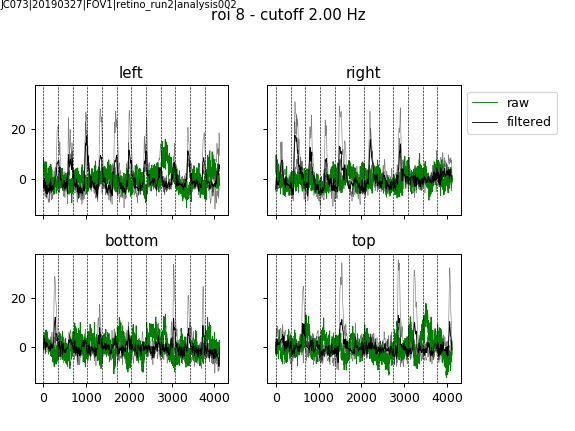

traces_by_cond_roi00008_lowpass2Hz
Saved to: /n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_ea177a/visualization/rf_estimates/parsed_cycles_by_roi


In [733]:
filt_traces = {}
for cond in trials_by_cond.keys():
    filt_traces[cond] = np.empty(roi_traces[cond].shape, dtype=roi_traces[cond].dtype)
    for repnum in np.arange(0, roi_traces[cond].shape[0]):
        y = butter_lowpass_filter(roi_traces[cond][repnum,:], cutoff, fs, order)
        filt_traces[cond][repnum, :] = y


fig, axes = pl.subplots(2,2, sharex=True, sharey=True) #, figsize=(8,))

for aix, cond in enumerate(['left', 'right', 'bottom', 'top']):
    ax = axes.flat[aix]
    for repnum in np.arange(0, filt_traces[cond].shape[0]):
        ax.plot(filt_traces[cond][repnum, :], 'k', alpha=0.5, lw=0.5)
    filt_label = 'filtered' if aix==1 else None
    raw_label = 'raw' if aix==1 else None
    ax.plot(tmp_traces[cond].mean(axis=0), 'g', alpha=1, linewidth=0.7, label=raw_label)
    ax.plot(filt_traces[cond].mean(axis=0), 'k', linewidth=0.7, label=filt_label)
    ax.set_title(cond)
    for cyc in stiminfo[cond]['cycle_start_ixs']:
        ax.axvline(x=cyc, color='k', linestyle='--', linewidth=0.5)
        
fig.suptitle("roi %i - cutoff %.2f Hz" % (int(rid+1), cutoff))
pl.subplots_adjust(hspace=0.3, top=0.8, left=0.06, right=0.8)
axes.flat[1].legend(bbox_to_anchor=(1, 1))

label_figure(fig, data_identifier)
figname = 'traces_by_cond_roi%05d_lowpass%iHz' % (int(rid+1), cutoff) #%.2f'
pl.savefig(os.path.join(curr_figdir, '%s.png' % figname))
print figname
print "Saved to:", curr_figdir

# Get averaged "cycle" and identify onset/offset and peaks

### RF estimates for all ROIs

In [771]:
roi_list = absolute_coords['strong_cells']
chunksize = 1
plot_each_condition = True
filter_traces = True

# Set params for calcuting "onset" response:
nstds_above_baseline = 2
window_nsecs = 0.5

# Plot colors:
c1_color = 'blue'
c2_color = 'orange'


6
top: (3, 4119)
right: (3, 4119)
left: (3, 4119)
bottom: (3, 4119)


<IPython.core.display.Javascript object>


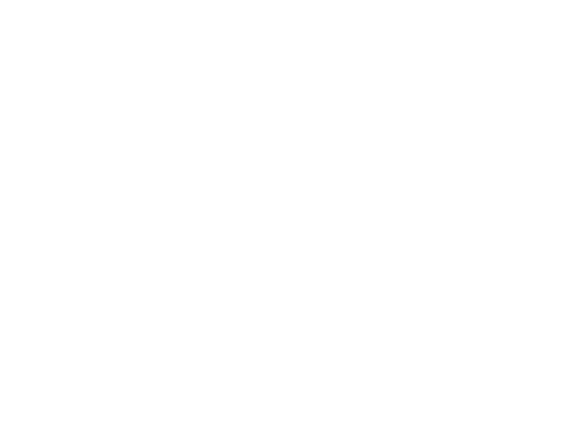

traces_by_cond_roi00007_lowpass2Hz
Saving ROI figures to: /n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_ea177a/visualization/rf_estimates/parsed_cycles_by_roi


<IPython.core.display.Javascript object>


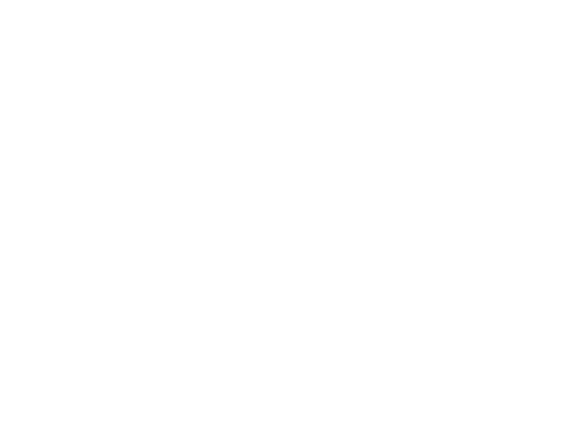

avg_1cycle_by_cond_roi00007


<IPython.core.display.Javascript object>


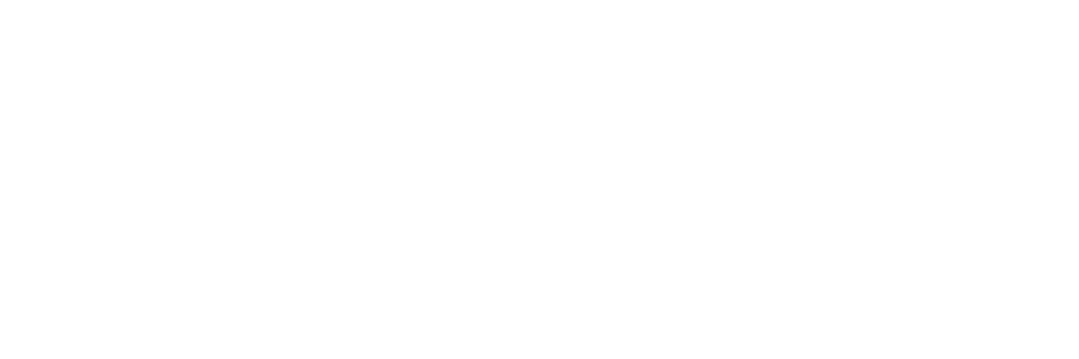

time_v_intensity_cycle_loci_1cycle_by_cond_roi00007
[top] Onset 53.77 deg (std 0.00). Peak @ 30.91 deg.
[right] Onset 59.12 deg (std 0.00). Peak @ 58.77 deg.
[bottom] Onset -41.34 deg (std 0.00). Peak @ -38.44 deg.
[left] Onset -52.32 deg (std 0.00). Peak @ -24.39 deg.
Relative coords? False
Lin coords from phase x, y = (-25.99, -7.53)
ROI 7 - summary - 
Phase coords (x, y): (-25.99, -7.53)
Left/Right edges: [-52.32, 59.12]
--> left onsets: [-52.31522277]
--> right onsets: [ 59.12196743]
Bottom/Top edges: [-41.34, 53.77]
--> top onsets: [ 53.77191651]
--> bottom onsets: [-41.33646841]


<IPython.core.display.Javascript object>


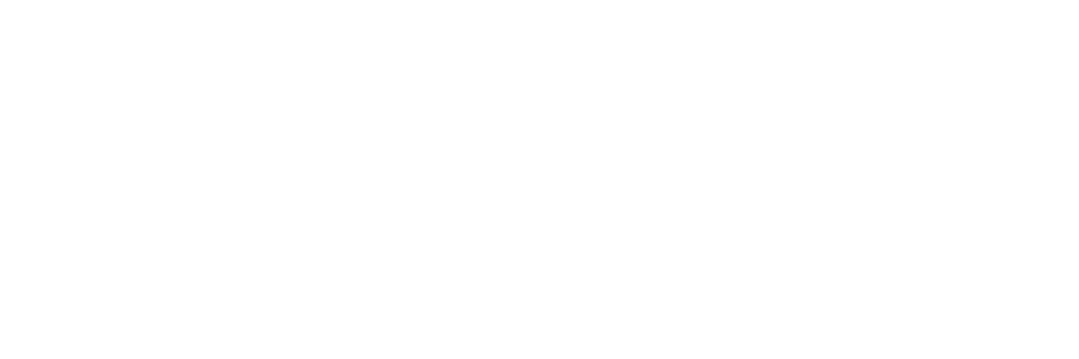

position_v_intensity_cycle_loci_1cycle_by_cond_roi00007


<IPython.core.display.Javascript object>


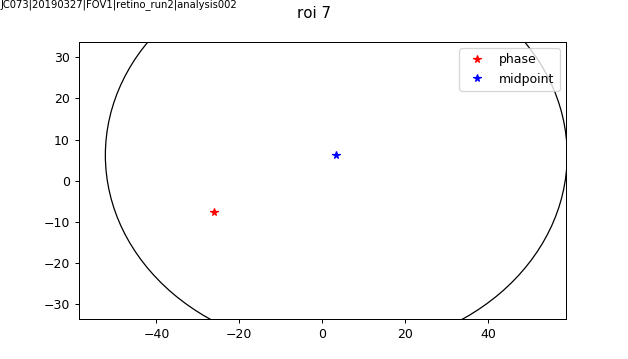

7
top: (3, 4119)
right: (3, 4119)
left: (3, 4119)
bottom: (3, 4119)


<IPython.core.display.Javascript object>


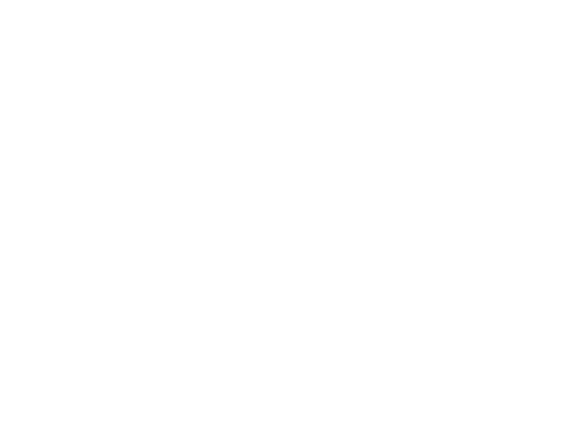

traces_by_cond_roi00008_lowpass2Hz
Saving ROI figures to: /n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_ea177a/visualization/rf_estimates/parsed_cycles_by_roi


<IPython.core.display.Javascript object>


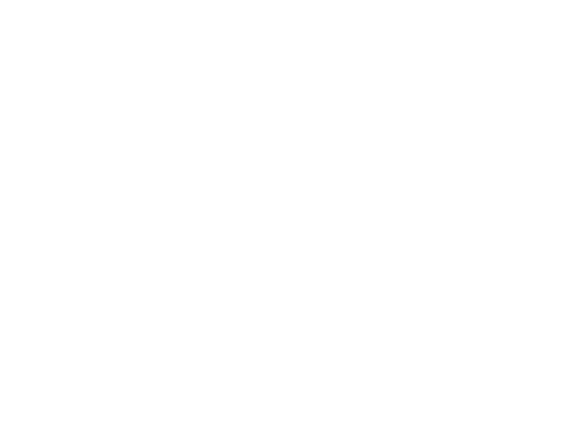

avg_1cycle_by_cond_roi00008


<IPython.core.display.Javascript object>


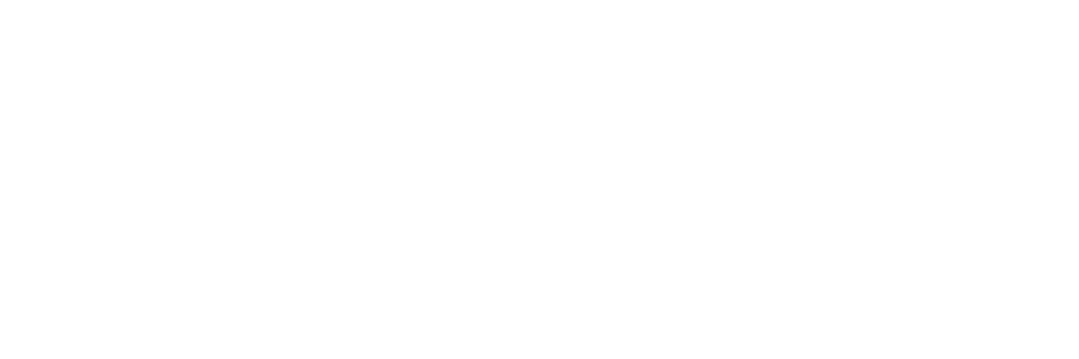

time_v_intensity_cycle_loci_1cycle_by_cond_roi00008
[top] Onset 25.83 deg (std 0.00). Peak @ 12.05 deg.
[right] Onset 37.36 deg (std 0.00). Peak @ 9.79 deg.
[bottom] Onset 17.07 deg (std 0.00). Peak @ 44.64 deg.
[left] Onset 20.60 deg (std 0.00). Peak @ 57.24 deg.
Relative coords? False
Lin coords from phase x, y = (31.57, -19.77)
ROI 8 - summary - 
Phase coords (x, y): (31.57, -19.77)
Left/Right edges: [20.60, 37.36]
--> left onsets: [ 20.59719649]
--> right onsets: [ 37.35768525]
Bottom/Top edges: [17.07, 25.83]
--> top onsets: [ 25.83106969]
--> bottom onsets: [ 17.07262548]


<IPython.core.display.Javascript object>


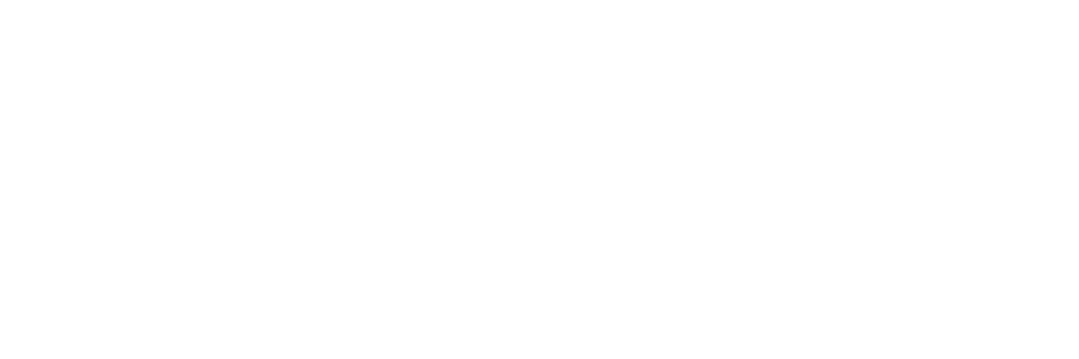

position_v_intensity_cycle_loci_1cycle_by_cond_roi00008


<IPython.core.display.Javascript object>


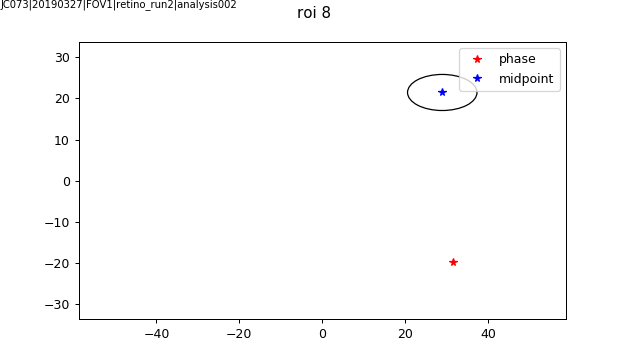

99
top: (3, 4119)
right: (3, 4119)
left: (3, 4119)
bottom: (3, 4119)


<IPython.core.display.Javascript object>


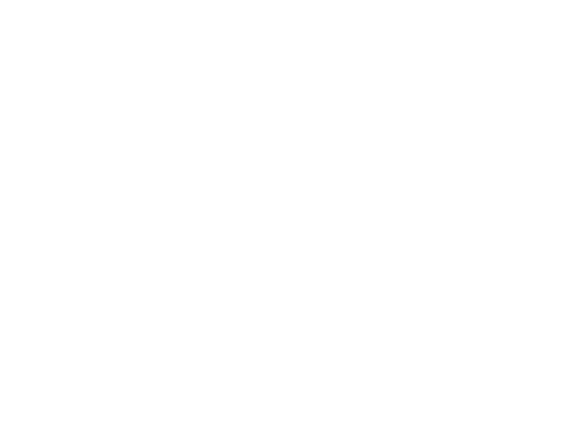

traces_by_cond_roi00100_lowpass2Hz
Saving ROI figures to: /n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_ea177a/visualization/rf_estimates/parsed_cycles_by_roi


<IPython.core.display.Javascript object>


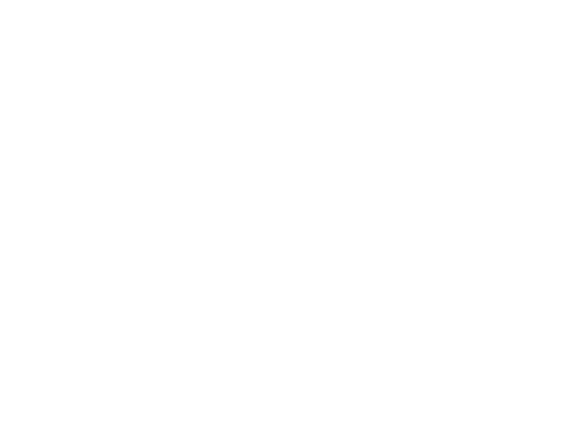

avg_1cycle_by_cond_roi00100


<IPython.core.display.Javascript object>


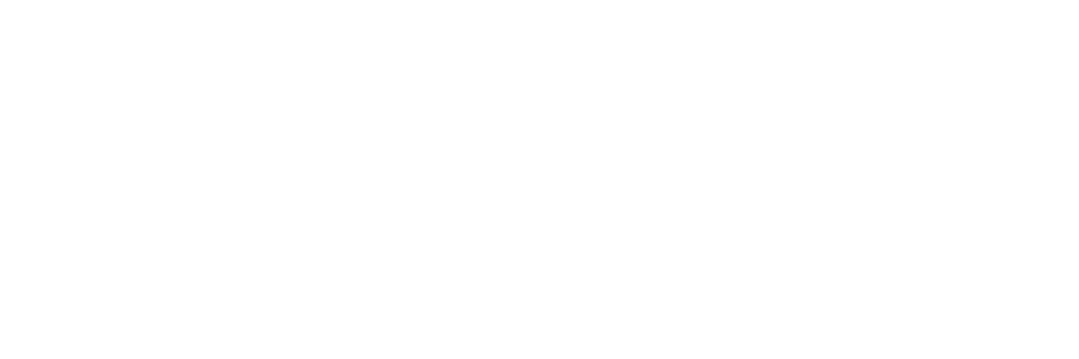

time_v_intensity_cycle_loci_1cycle_by_cond_roi00100
[top] Onset 29.46 deg (std 0.00). Peak @ -20.97 deg.
[right] Onset 26.11 deg (std 0.00). Peak @ -18.51 deg.
[bottom] Onset 0.39 deg (std 0.00). Peak @ 16.70 deg.
[left] Onset -24.39 deg (std 0.00). Peak @ 4.27 deg.
Relative coords? False
Lin coords from phase x, y = (4.72, -5.44)
ROI 100 - summary - 
Phase coords (x, y): (4.72, -5.44)
Left/Right edges: [-24.39, 26.11]
--> left onsets: [-24.3870142]
--> right onsets: [ 26.10775365]
Bottom/Top edges: [0.39, 29.46]
--> top onsets: [ 29.46394309]
--> bottom onsets: [ 0.38692224]


<IPython.core.display.Javascript object>


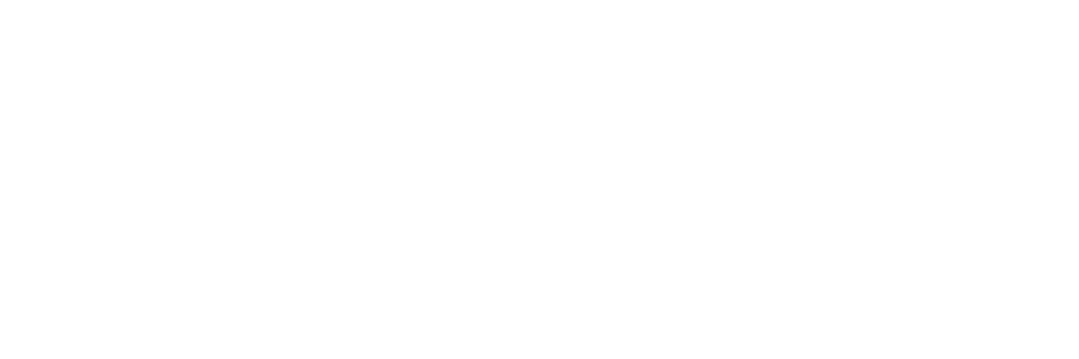

position_v_intensity_cycle_loci_1cycle_by_cond_roi00100


<IPython.core.display.Javascript object>


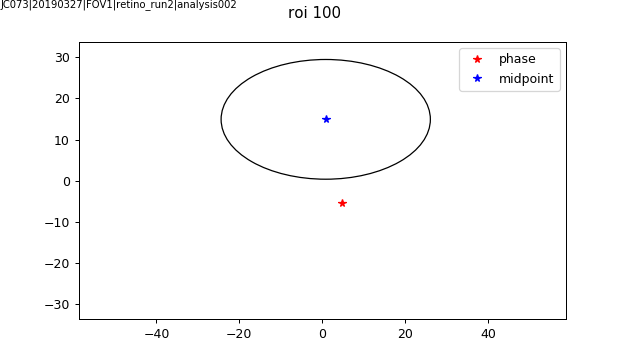

In [772]:
#### Parse roi trace for each trial into N chunks

c1 = 'right'
c2 = 'left'


parsing_results = {}
rf_results = {}
processing_results = {}
for rid in roi_list:
    print rid
    raw_traces= dict()
    for cond in trials_by_cond.keys():
        raw_traces[cond] = np.array([extr_traces['File%03d' % f]['processed'][rid, :] for f in trials_by_cond[cond]])
        print"%s:" % cond, raw_traces[cond].shape
        
    # Filter traces
    filt_traces = {}
    for cond in raw_traces.keys():
        filt_traces[cond] = np.empty(raw_traces[cond].shape, dtype=raw_traces[cond].dtype)
        for repnum in np.arange(0, raw_traces[cond].shape[0]):
            y = butter_lowpass_filter(raw_traces[cond][repnum,:], cutoff, fs, order)
            filt_traces[cond][repnum, :] = y

    if plot_each_condition:
        curr_figdir = os.path.join(output_dir, 'traces_by_roi')
        if not os.path.exists(curr_figdir):
            os.makedirs(curr_figdir)
            
        fig, axes = pl.subplots(2,2, sharex=True, sharey=True) #, figsize=(8,))
        for aix, cond in enumerate(['left', 'right', 'bottom', 'top']):
            ax = axes.flat[aix]
            for repnum in np.arange(0, filt_traces[cond].shape[0]):
                ax.plot(filt_traces[cond][repnum, :], 'k', alpha=0.5, lw=0.5)
            filt_label = 'filtered' if aix==1 else None
            raw_label = 'raw' if aix==1 else None
            ax.plot(raw_traces[cond].mean(axis=0), 'g', alpha=1, linewidth=0.7, label=raw_label)
            ax.plot(filt_traces[cond].mean(axis=0), 'k', linewidth=0.7, label=filt_label)
            ax.set_title(cond)
            for cyc in stiminfo[cond]['cycle_start_ixs']:
                ax.axvline(x=cyc, color='k', linestyle='--', linewidth=0.5)
        fig.suptitle("roi %i - cutoff %.2f Hz" % (int(rid+1), cutoff))
        pl.subplots_adjust(hspace=0.3, top=0.8, left=0.06, right=0.8)
        axes.flat[1].legend(bbox_to_anchor=(1, 1))
        
        figname = 'traces_by_cond_roi%05d_lowpass%iHz' % (int(rid+1), cutoff) #%.2f'
        pl.savefig(os.path.join(curr_figdir, '%s.png' % figname))
        print figname
        pl.close()
                
    if filter_traces:
        roi_traces = copy.copy(filt_traces)
    else:
        roi_traces = copy.copy(raw_traces)

    #### Get average N cycles and visualize chunked traces
    parsed_traces, parsed_cycle_ixs = get_parsed_cycles(rid, roi_traces, stiminfo, chunksize=chunksize)

    #### Plot averaged cycles by condition:
    curr_figdir = os.path.join(output_dir, 'parsed_cycles_by_roi')
    if not os.path.exists(curr_figdir):
        os.makedirs(curr_figdir)
    print "Saving ROI figures to: %s" % curr_figdir

    fig = plot_parsed_cycles_by_roi(parsed_traces, parsed_cycle_ixs)
    pl.suptitle('roi %i' % int(rid+1))
    label_figure(fig, data_identifier)
    figname = 'avg_%icycle_by_cond_roi%05d' % (chunksize, int(rid+1))
    pl.savefig(os.path.join(output_dir, 'parsed_cycles_by_roi', '%s.png' % figname))
    print figname
    pl.close()

    #### Identify max, min, and "onset" frame in averaged trace
    loci = get_loci_from_averaged_cycle(parsed_traces, parsed_cycle_ixs, stiminfo, \
                                            nstds_above_baseline=nstds_above_baseline, window_nsecs=window_nsecs)

    processing_results[rid] = {'filter_traces': filter_traces,
                          'lowpass_cutoff': cutoff,
                          'filtered_traces': filt_traces,
                          'raw_traces': raw_traces}
    
    parsing_results[rid] = {'parsed_traces': parsed_traces,
                            'parsed_cycle_ixs': parsed_cycle_ixs,
                            'chunksize': chunksize,
                            'roi_traces': roi_traces,
                            'loci': loci}
    
    #### Plot averaged mini-trace, with key loci
    if any([cond_loci is None for cond, cond_loci in loci.items()]):
        print "*** BAD FITS: roi %i" % int(rid+1)
        bad_conds = [cond for cond, cond_loci in loci.items() if cond_loci is None]
        for cond in bad_conds:
            print "Unable to fit cond: %s" % cond
        continue
        
    fig = plot_loci_from_averaged_cycle(parsed_traces, parsed_cycle_ixs, loci) #, averaged_=None)

    fig.suptitle('roi %i (%i chunks)' % (int(rid+1), chunksize))
    pl.subplots_adjust(wspace=0.2, hspace=0.5, left=0.05, top=0.8)
    label_figure(fig, data_identifier)
    figname = 'time_v_intensity_cycle_loci_%icycle_by_cond_roi%05d' % (chunksize, int(rid+1))
    pl.savefig(os.path.join(output_dir, 'parsed_cycles_by_roi', '%s.png' % figname))
    print figname
    pl.close()

    ### Use interp stim positions to get bar position at each locus
    positions_by_cycle = get_positions_per_cycle(stim_positions, parsed_cycle_ixs)
    rf_edges = loci_to_rf_parameters(loci, positions_by_cycle)
    print "Relative coords?", absolute_coords['used_relative']
    print "Lin coords from phase x, y = (%.2f, %.2f)" % (absolute_coords['linX'][rid], absolute_coords['linY'][rid])
    rf_params = get_rf_estimate_params(rid, absolute_coords, rf_edges, verbose=True)

    #### Plot averaged cycle using SPACE coords:
    average_positions = {}
    for c1 in parsed_traces.keys():
        average_positions[c1] = np.array(rf_edges[c1]['bar_positions']).mean(axis=0)

    rf_results[rid] = {'positions_by_cycle': positions_by_cycle,
                      'rf_edges': rf_edges,
                      'rf_params': rf_params}
        
    fig = plot_loci_from_averaged_cycle(parsed_traces, parsed_cycle_ixs, loci, average_positions=average_positions)    
    fig.suptitle('roi %i (%i chunks)' % (int(rid+1), chunksize))
    pl.subplots_adjust(wspace=0.2, hspace=0.5, left=0.05, top=0.8)
    label_figure(fig, data_identifier)
    figname = 'position_v_intensity_cycle_loci_%icycle_by_cond_roi%05d' % (chunksize, int(rid+1))
    pl.savefig(os.path.join(output_dir, 'parsed_cycles_by_roi', '%s.png' % figname))
    print figname
    pl.close()

    # Use calculated edges of RF to draw ellipse
    curr_figdir = os.path.join(output_dir, 'estimates_by_roi')
    if not os.path.exists(curr_figdir):
        os.makedirs(curr_figdir)

    fig = plot_roi_RF(rf_params, screen_info)
    fig.suptitle('roi %i' % int(rid+1))
    label_figure(fig, data_identifier)
    pl.savefig(os.path.join(curr_figdir, 'rf_estimate_roi%05d.png' % int(rid+1)))

In [773]:
rf_estimate_info = {'traces': processing_results,
                    'parsing_results': parsing_results,
                    'rf_results': rf_results,
                    'stiminfo': stiminfo,
                    'roi_list': roi_list,
                    'mag_thr': mag_thr}

rf_estimate_fpath = os.path.join(output_dir, 'rf_estimate_results.pkl')
with open(rf_estimate_fpath, 'wb') as f:
    pkl.dump(rf_estimate_info, f, protocol=pkl.HIGHEST_PROTOCOL)
    
rf_params_fpath = os.path.join(output_dir, 'rf_estimate_params.json')
rf_params_info = {'roi_list': roi_list,
                 'mag_thr': mag_thr,
                 'used_relative_phase': absolute_coords['used_relative'],
                 'delay_thr': delay_thr,
                 'chunksize': chunksize}
with open(rf_params_fpath, 'w') as f:
    json.dump(rf_params_info, f, indent=4)
    

# Look at single ROI:

In [736]:
rid = 7

7


<IPython.core.display.Javascript object>


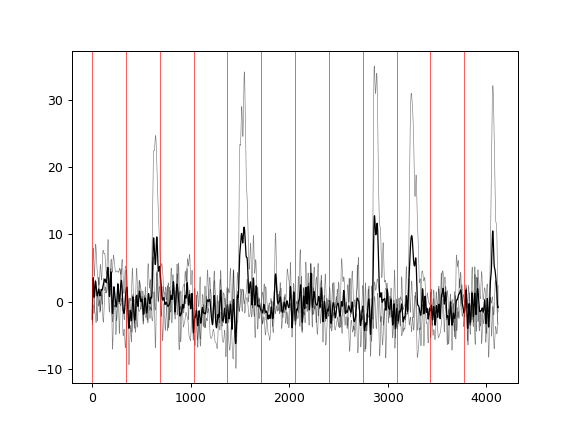

In [742]:
print rid

c1 = 'top'
raw_traces = processing_results[rid]['raw_traces']
filt_traces = processing_results[rid]['filtered_traces']

roi_traces = copy.copy(filt_traces)

pl.figure()
for tr in np.arange(0, roi_traces[c1].shape[0]):
    pl.plot(roi_traces[c1][tr,:], 'k', lw=0.5, alpha=0.5)
pl.plot(roi_traces[c1].mean(axis=0), 'k', lw=1, alpha=1)
for cyc in stiminfo[c1]['cycle_start_ixs']:
    pl.axvline(x=cyc, color='r', lw=0.5)


In [465]:
import copy

Saving ROI figures to: /n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_ea177a/visualization/rf_estimates/parsed_cycles_by_roi


<IPython.core.display.Javascript object>


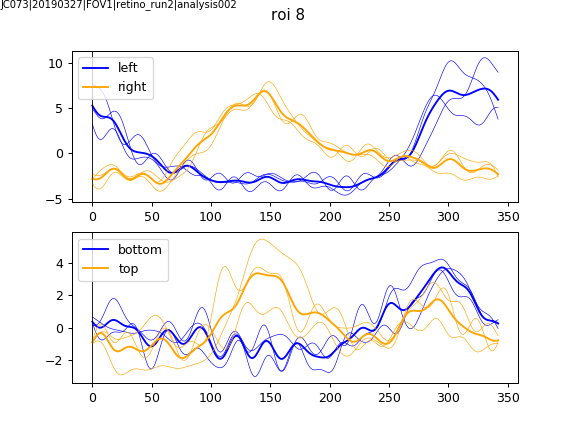

avg_1cycle_by_cond_roi00008


In [764]:
roi_traces = copy.copy(filt_traces)
chunksize = 1
plot_each_condition = False

# Set params for calcuting "onset" response:
nstds_above_baseline = 3.0
window_nsecs = 0.5

# Plot colors:
c1_color = 'blue'
c2_color = 'orange'
#%%


#### Get average N cycles and visualize chunked traces
parsed_traces, parsed_cycle_ixs = get_parsed_cycles(rid, roi_traces, stiminfo, chunksize=chunksize)

#### Plot averaged cycles by condition:
curr_figdir = os.path.join(output_dir, 'parsed_cycles_by_roi')
if not os.path.exists(curr_figdir):
    os.makedirs(curr_figdir)
print "Saving ROI figures to: %s" % curr_figdir

fig = plot_parsed_cycles_by_roi(parsed_traces, parsed_cycle_ixs)
pl.suptitle('roi %i' % int(rid+1))
label_figure(fig, data_identifier)
figname = 'avg_%icycle_by_cond_roi%05d' % (chunksize, int(rid+1))
#pl.savefig(os.path.join(output_dir, 'parsed_cycles_by_roi', '%s.png' % figname))
print figname
#pl.close()


###### Plot each rep's "sub cycle":

<IPython.core.display.Javascript object>


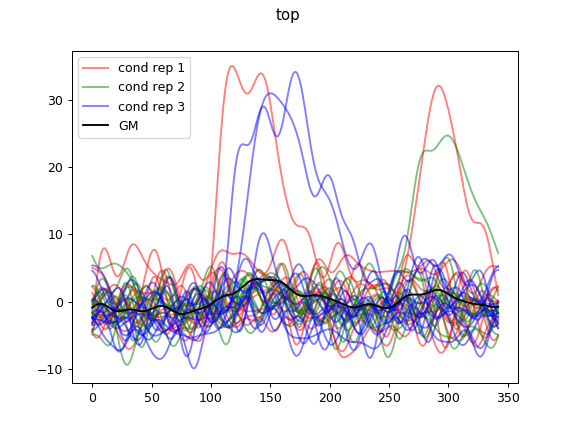

Text(0.5,0.98,u'top')

In [765]:
# Plot each rep's "sub cycle":
ncond_reps, nsubcycles_to_avg, nframes_in_subcycle = parsed_traces['left'].shape

condrep_colors = ['r', 'g', 'b', 'purple']
pl.figure()

for rep in range(ncond_reps):
    for subcycle in range(nsubcycles_to_avg):
        scycle_label = 'cond rep %i' % (int(rep+1)) if subcycle==0 else None
        pl.plot(parsed_traces[c1][rep, subcycle, :], color=condrep_colors[rep], label=scycle_label, alpha=0.5)
pl.plot(parsed_traces[c1].mean(axis=1).mean(axis=0), 'k', label='GM')
pl.legend()
pl.suptitle(c1)

###### Plot loci found for current roi's GM trace

In [766]:
def get_cycle_onsets(avg_cycle_c1, cycle_starts, fr_per_cyc, baseline_window_size=10., nstds_above_baseline=1.5):

    # Find peaks for each cycle:
    cmaxima = []
    cminima = []
    onsets = []
    baseline_values= []
    baseline_indices = []
    
    # Get max, min, and "onset" for each cycle in "mini" roi-trace:
    try:
        for cyc_ix, cyc_start in enumerate(cycle_starts):

            curr_frames = np.arange(cyc_start, cyc_start+fr_per_cyc)
            curr_values = avg_cycle_c1[curr_frames]
            cmax = int(np.where(curr_values==curr_values.max())[0][0])
            startix = 0
            if cmax == 0:
                while cmax < (fr_per_cyc / len(cycle_starts)): #4:
                    print "Getting new cmax..."
                    cmax = int(np.where(curr_values[startix:]==curr_values[startix:].max())[0][0])
                    startix += 1
                cmax = cmax + startix
            #elif (cmax - cmaxima[-1]) < (fr_per_cyc/2):
                
            cmaxima.append((curr_frames[cmax], curr_values.max()))

            minval = curr_values[startix:cmax].min()
            cmin = int(np.where(curr_values[startix:cmax]==minval)[0][0]) + startix
            cminima.append((curr_frames[cmin], minval))

            baseline = curr_values[cmin-baseline_window_size:cmin] #+baseline_window_size]
            bindices = curr_frames[cmin-baseline_window_size:cmin] #+baseline_window_size]
            if cmin-baseline_window_size < 0: # include frames from previous "cycle" since likely at very edge
                if cyc_ix == 0:
                    # No previous cycle to borrow frames from
                    bindices = curr_frames[0:cmin+baseline_window_size]
                    baseline = curr_values[0:cmin+baseline_window_size]
                else:
                    prev_frames = np.arange(cycle_starts[cyc_ix-1], cycle_starts[cyc_ix-1]+fr_per_cyc)
                    prev_values = avg_cycle_c1[prev_frames]
                    nprev = baseline_window_size-cmin
                    bindices = curr_frames[0:cmin] #+baseline_window_size]
                    bindices = sorted(np.append(bindices, prev_frames[-nprev:]))

                    baseline = prev_values[-nprev:]
                    baseline = np.append(baseline, curr_values[0:cmin]) #+baseline_window_size])

            thr_value = baseline.mean() + (baseline.std() * nstds_above_baseline) #curr_values.max()*0.1
            onset = np.where(np.abs(curr_values[cmin:cmax]-thr_value)\
                             ==np.min(np.abs(curr_values[cmin:cmax]-thr_value)))[0] + cmin # Only look b/w max/min 

            onsets.append((curr_frames[onset], curr_values[onset]))
            baseline_values.append(baseline)
            baseline_indices.append(bindices)
    except Exception as e:
        return None
        
    loci = {'maxima': cmaxima,
           'minima': cminima,
           'onsets': onsets,
           'baseline_indices': baseline_indices,
           'baseline_values': baseline_values,
           'nstds_above_baseline': nstds_above_baseline}
        
    return loci #cmaxima, cminima, onsets, (baseline_indices, baseline_values)

        

In [767]:
parsed_cycle_ixs[c1]

array([[[    0.],
        [  343.],
        [  686.],
        [ 1029.],
        [ 1372.],
        [ 1715.],
        [ 2058.],
        [ 2401.],
        [ 2744.],
        [ 3087.],
        [ 3430.],
        [ 3773.]],

       [[    0.],
        [  343.],
        [  686.],
        [ 1029.],
        [ 1372.],
        [ 1715.],
        [ 2058.],
        [ 2401.],
        [ 2744.],
        [ 3087.],
        [ 3430.],
        [ 3773.]],

       [[    0.],
        [  343.],
        [  686.],
        [ 1029.],
        [ 1372.],
        [ 1715.],
        [ 2058.],
        [ 2401.],
        [ 2744.],
        [ 3087.],
        [ 3430.],
        [ 3773.]]])

In [768]:
cycle_starts = [int(c) for c in parsed_cycle_ixs[c1].mean(axis=0)[0,:]] # only need first chunk
print cycle_starts

[0]


<IPython.core.display.Javascript object>


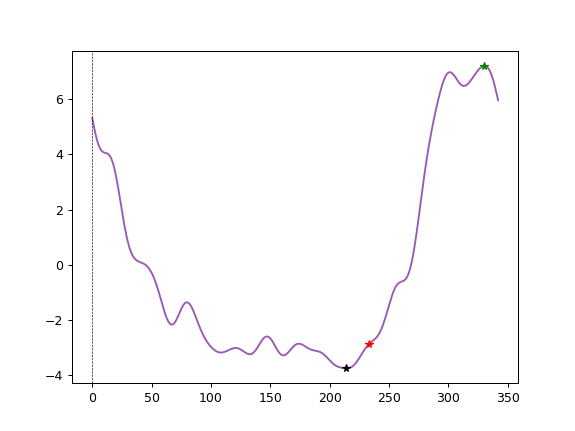

In [769]:

#### Identify max, min, and "onset" frame in averaged trace
loci = get_loci_from_averaged_cycle(parsed_traces, parsed_cycle_ixs, stiminfo, \
                                        nstds_above_baseline=nstds_above_baseline, window_nsecs=window_nsecs)


pl.figure()
pl.plot(parsed_traces['left'].mean(axis=1).mean(axis=0))
for cyc in parsed_cycle_ixs[c1][0][0]:
    pl.axvline(x=cyc, linestyle='--', color='k', linewidth=0.5)
for mn in loci['left']['maxima']:
    pl.plot(mn[0], mn[1], 'g*')
for mn in loci['left']['minima']:
    pl.plot(mn[0], mn[1], 'k*')
for on in loci['left']['onsets']:
    pl.plot(on[0], on[1], 'r*')

#### Plot onset-peak for each subcycle

<IPython.core.display.Javascript object>


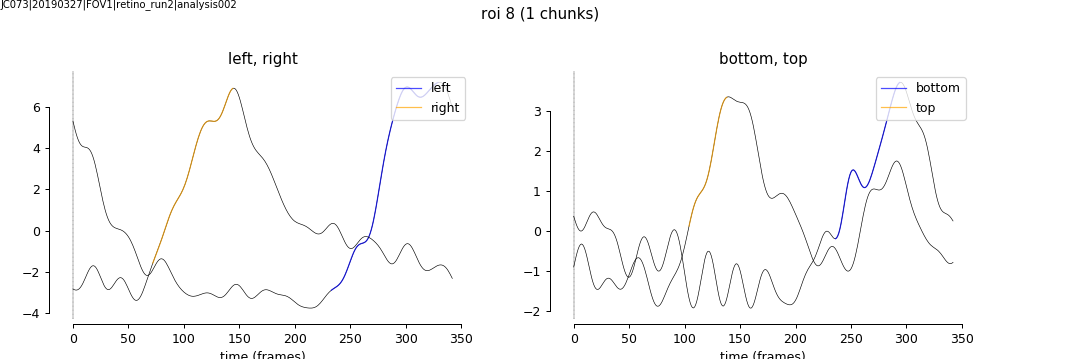

time_v_intensity_cycle_loci_1cycle_by_cond_roi00008


In [770]:

#### Plot averaged mini-trace, with key loci
fig = plot_loci_from_averaged_cycle(parsed_traces, parsed_cycle_ixs, loci) #, averaged_=None)

fig.suptitle('roi %i (%i chunks)' % (int(rid+1), chunksize))
pl.subplots_adjust(wspace=0.2, hspace=0.5, left=0.05, top=0.8)
label_figure(fig, data_identifier)
figname = 'time_v_intensity_cycle_loci_%icycle_by_cond_roi%05d' % (chunksize, int(rid+1))
pl.savefig(os.path.join(output_dir, 'parsed_cycles_by_roi', '%s.png' % figname))
print figname
#pl.close()

##### Plot onset-peak by POSITION:

[top] Onset 4.15 deg (std 18.43). Peak @ -14.35 deg.
[right] Onset 35.49 deg (std 0.67). Peak @ 9.73 deg.
[bottom] Onset 26.92 deg (std 5.39). Peak @ 45.06 deg.
[left] Onset 24.33 deg (std 3.89). Peak @ 52.44 deg.
Relative coords? False
Lin coords from phase x, y = (31.57, -19.77)
ROI 8 - summary - 
Phase coords (x, y): (31.57, -19.77)
Left/Right edges: [24.33, 35.49]
--> left onsets: [ 28.22120941  20.4335029 ]
--> right onsets: [ 34.81849529  36.15936688]
Bottom/Top edges: [26.92, 4.15]
--> top onsets: [ 22.57346956 -14.27853019]
--> bottom onsets: [ 32.30275003  21.52804379]


<IPython.core.display.Javascript object>


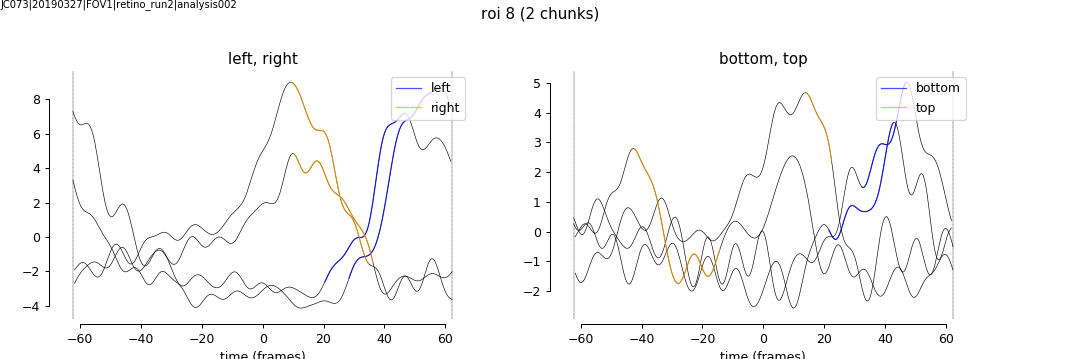

position_v_intensity_cycle_loci_2cycle_by_cond_roi00008


In [730]:

### Use interp stim positions to get bar position at each locus
positions_by_cycle = get_positions_per_cycle(stim_positions, parsed_cycle_ixs)
rf_edges = loci_to_rf_parameters(loci, positions_by_cycle)
print "Relative coords?", absolute_coords['used_relative']
print "Lin coords from phase x, y = (%.2f, %.2f)" % (absolute_coords['linX'][rid], absolute_coords['linY'][rid])
rfparams = get_rf_estimate_params(rid, absolute_coords, rf_edges, verbose=True)

#### Plot averaged cycle using SPACE coords:
average_positions = {}
for c1 in parsed_traces.keys():
    average_positions[c1] = np.array(rf_edges[c1]['bar_positions']).mean(axis=0)

fig = plot_loci_from_averaged_cycle(parsed_traces, parsed_cycle_ixs, loci, average_positions=average_positions)    
fig.suptitle('roi %i (%i chunks)' % (int(rid+1), chunksize))
pl.subplots_adjust(wspace=0.2, hspace=0.5, left=0.05, top=0.8)
label_figure(fig, data_identifier)
figname = 'position_v_intensity_cycle_loci_%icycle_by_cond_roi%05d' % (chunksize, int(rid+1))
pl.savefig(os.path.join(output_dir, 'parsed_cycles_by_roi', '%s.png' % figname))
print figname
#pl.close()


<IPython.core.display.Javascript object>


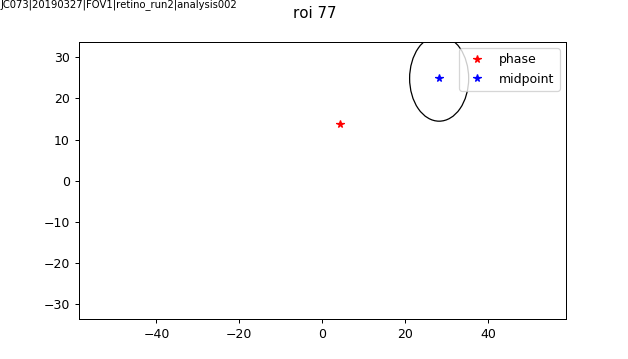

In [490]:

# Use calculated edges of RF to draw ellipse
curr_figdir = os.path.join(output_dir, 'estimates_by_roi')
if not os.path.exists(curr_figdir):
    os.makedirs(curr_figdir)

fig = plot_roi_RF(rfparams, screen_info)
fig.suptitle('roi %i' % int(rid+1))
label_figure(fig, data_identifier)
pl.savefig(os.path.join(curr_figdir, 'rf_estimate_roi%05d.png' % int(rid+1)))

In [348]:
print c1, "start"
print stim_positions[c1].head()

print c1, "tail"
print stim_positions[c1].tail()

bottom start
          12         2          5 
0 -60.690170 -60.690170 -60.690170
1 -60.422246 -60.480607 -60.580831
2 -60.067673 -60.115032 -60.212198
3 -59.709886 -59.758302 -59.863111
4 -59.348544 -59.396028 -59.488295
bottom tail
             12         2          5 
4120  64.662803  64.427702  64.575288
4121  65.027826  64.764318  64.928753
4122  65.392849  65.100935  65.282218
4123  65.757873  65.437552  65.635684
4124  66.122896  65.774168  65.989149


In [371]:
print c2, "start"
print stim_positions[c2].head()

print c2, "tail"
print stim_positions[c2].tail()

top start
          10         1          7 
0  60.690170  60.690170  60.690170
1  60.366302  60.437931  60.306079
2  60.015209  60.077796  59.948720
3  59.658968  59.722217  59.602462
4  59.289903  59.352993  59.237856
top tail
             10         1          7 
4120 -64.777292 -64.682674 -64.642937
4121 -65.153484 -65.050596 -65.004847
4122 -65.529677 -65.418517 -65.366757
4123 -65.905870 -65.786439 -65.728667
4124 -66.282062 -66.154360 -66.090577
